# 작전도로 상태 점검을 위한 노면 이상 탐지 모델 개발

## 환경 설정
본 베이스라인 코드를 활용하기 위한 베이스라인 환경을 설정합니다.

In [1]:
!pip install -r requirements.txt

  Using cached asttokens-2.4.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached certifi-2024.7.4-py3-none-any.whl.metadata (2.2 kB)
  Using cached charset_normalizer-3.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (33 kB)
  Using cached comm-0.2.2-py3-none-any.whl.metadata (3.7 kB)
  Using cached contourpy-1.2.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached debugpy-1.8.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached executing-2.0.1-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached fonttools-4.53.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_

## 데이터 불러오기

In [1]:
import json
import os
import shutil

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from PIL import Image
from tqdm import tqdm

DATASET_ROOT = "/root/caicon/data"  # 데이터 셋의 루트 디렉토리
LABELS_DIR = "labels"
IMAGE_DIR = "images"
TRAIN_DIR = "train"
TEST_DIR = "test"

# DATASET_ROOT/train/labels: 학습 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/train/images: 학습 데이터의 이미지 파일이 있는 디렉토리
# DATASET_ROOT/test/labels: 테스트 데이터의 라벨 파일이 있는 디렉토리
# DATASET_ROOT/test/images: 테스트 데이터의 이미지 파일이 있는 디렉토리

In [2]:
import os
import cv2
import random
from PIL import Image
import sys
sys.path.append('/path/to/your/virtualenv/lib/python3.x/site-packages')
import subprocess
import sys

import albumentations as A
from glob import glob
import shutil


# 경로 설정
image_dir = '/root/caicon/data/train/images'  # 이미지 파일이 저장된 디렉토리
label_dir = '/root/caicon/data/train/labels'  # 라벨 파일이 저장된 디렉토리
save_dir = '/root/agmented_train/images'  # 증강된 이미지 저장 디렉토리
save_label_dir = '/root/agmented_train/labels'  # 증강된 레이블 저장 디렉토리

# 디렉토리 없으면 생성
os.makedirs(save_dir, exist_ok=True)
os.makedirs(save_label_dir, exist_ok=True)

# crack class 번호 (예시: crack 클래스 번호가 0이라고 가정)
crack_class_id = 0

# 증강에 사용할 albumentations transform 정의
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
])

# 이미지 파일 리스트 가져오기
image_paths = glob(os.path.join(image_dir, '*.jpg'))
augmentation_factor = 3  # 한 이미지당 몇 개의 증강 이미지를 생성할 것인지

for image_path in image_paths:
    img_name = os.path.basename(image_path)
    label_path = os.path.join(label_dir, img_name.replace('.jpg', '.txt'))
    
    # 레이블 파일이 존재하는지 확인
    if not os.path.exists(label_path):
        continue
    
    # 레이블 파일에서 crack class가 있는지 확인
    with open(label_path, 'r') as label_file:
        labels = label_file.readlines()
    
    has_crack_class = any(int(label.split()[0]) == crack_class_id for label in labels)
    
    if not has_crack_class:
        continue  # crack class가 없으면 스킵
    
    # 이미지 불러오기
    image = cv2.imread(image_path)
    
    for i in range(augmentation_factor):
        # 증강 적용
        augmented = transform(image=image)
        augmented_image = augmented['image']
        
        # 증강된 이미지 저장
        new_image_name = f"{os.path.splitext(img_name)[0]}_aug_{i}.jpg"
        save_image_path = os.path.join(save_dir, new_image_name)
        cv2.imwrite(save_image_path, augmented_image)
        
        # 해당 이미지의 레이블 파일 복사
        new_label_name = new_image_name.replace('.jpg', '.txt')
        save_label_path = os.path.join(save_label_dir, new_label_name)
        shutil.copy(label_path, save_label_path)

print(f"Crack class 이미지 증강 완료. {save_dir}에 저장되었습니다.")

OSError: [Errno 28] No space left on device: '/root/agmented_train/labels/0cc4d9c2bf9c7e0f479f0299_aug_0.txt'

In [4]:
import os

def count_files_in_directory(directory):
    # 디렉토리 내 모든 파일을 세는 함수
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)  # 파일 개수를 누적
    return file_count

# 사용할 디렉토리 경로 설정
directory_path ='/root/agmented_train/labels'

# 파일 개수 출력
print(f"총 파일 개수: {count_files_in_directory(directory_path)}")


총 파일 개수: 4449


### 학습 데이터 불러오기

In [2]:
train_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TRAIN_DIR, IMAGE_DIR, image)
    label_path = os.path.join(DATASET_ROOT, TRAIN_DIR, LABELS_DIR, image_id + ".txt")
    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])
                x = float(line.split()[1])
                y = float(line.split()[2])
                w = float(line.split()[3])
                h = float(line.split()[4])
                labels.append({"class_id": class_id, "x": x, "y": y, "w": w, "h": h})

    train_data.append({"id": image_id, "image_path": image_path, "label_path": label_path, "labels": labels})

df_train = pd.DataFrame(train_data)
df_train.head()

  0%|          | 0/30338 [00:00<?, ?it/s]

100%|██████████| 30338/30338 [00:01<00:00, 21245.06it/s]


id  \
0  0005bea020431c0d3bf256d6   
1  0006b448e0459c7541e68c98   
2  0008ad0376c928fd004e773c   
3  000c84f0755f05bdd4f5e62f   
4  000d3d731b166a1c7c68ee53   

                                          image_path  \
0  /root/caicon/data/train/images/0005bea020431c0...   
1  /root/caicon/data/train/images/0006b448e0459c7...   
2  /root/caicon/data/train/images/0008ad0376c928f...   
3  /root/caicon/data/train/images/000c84f0755f05b...   
4  /root/caicon/data/train/images/000d3d731b166a1...   

                                          label_path  \
0  /root/caicon/data/train/labels/0005bea020431c0...   
1  /root/caicon/data/train/labels/0006b448e0459c7...   
2  /root/caicon/data/train/labels/0008ad0376c928f...   
3  /root/caicon/data/train/labels/000c84f0755f05b...   
4  /root/caicon/data/train/labels/000d3d731b166a1...   

                                              labels  
0  [{'class_id': 0, 'x': 0.33377864583333333, 'y'...  
1  [{'class_id': 0, 'x': 0.36881510416666674, 'y'...  
2  [{'class_id': 0, 'x': 0.5819895833333334, 'y':...  
3  [{'class_id': 0, 'x': 0.6130546875, 'y': 0.641...  
4  [{'class_id': 0, 'x': 0.0248984375, 'y': 0.079...

### 테스트 데이터 불러오기

In [4]:
test_data = []

for image in tqdm(os.listdir(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR))):
    image_id = image.split(".")[0]
    image_path = os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, image)

    # 테스트 데이터는 라벨 파일이 없습니다.
    test_data.append({"id": image_id, "image_path": image_path, "label_path": "", "labels": []})

df_test = pd.DataFrame(test_data)
df_test.head()

100%|██████████| 7043/7043 [00:00<00:00, 71918.93it/s]


id  \
0  000055e8f6d122e994484757   
1  0005b3cac344a76e24863aaf   
2  000bb5c5ce578b148414b592   
3  000e2f6cccfec91021c9e353   
4  000f949f37337be8615f58ca   

                                          image_path label_path labels  
0  /root/caicon/data/test/images/000055e8f6d122e9...                []  
1  /root/caicon/data/test/images/0005b3cac344a76e...                []  
2  /root/caicon/data/test/images/000bb5c5ce578b14...                []  
3  /root/caicon/data/test/images/000e2f6cccfec910...                []  
4  /root/caicon/data/test/images/000f949f37337be8...                []

## 샘플 데이터 확인하기

### 샘플 이미지

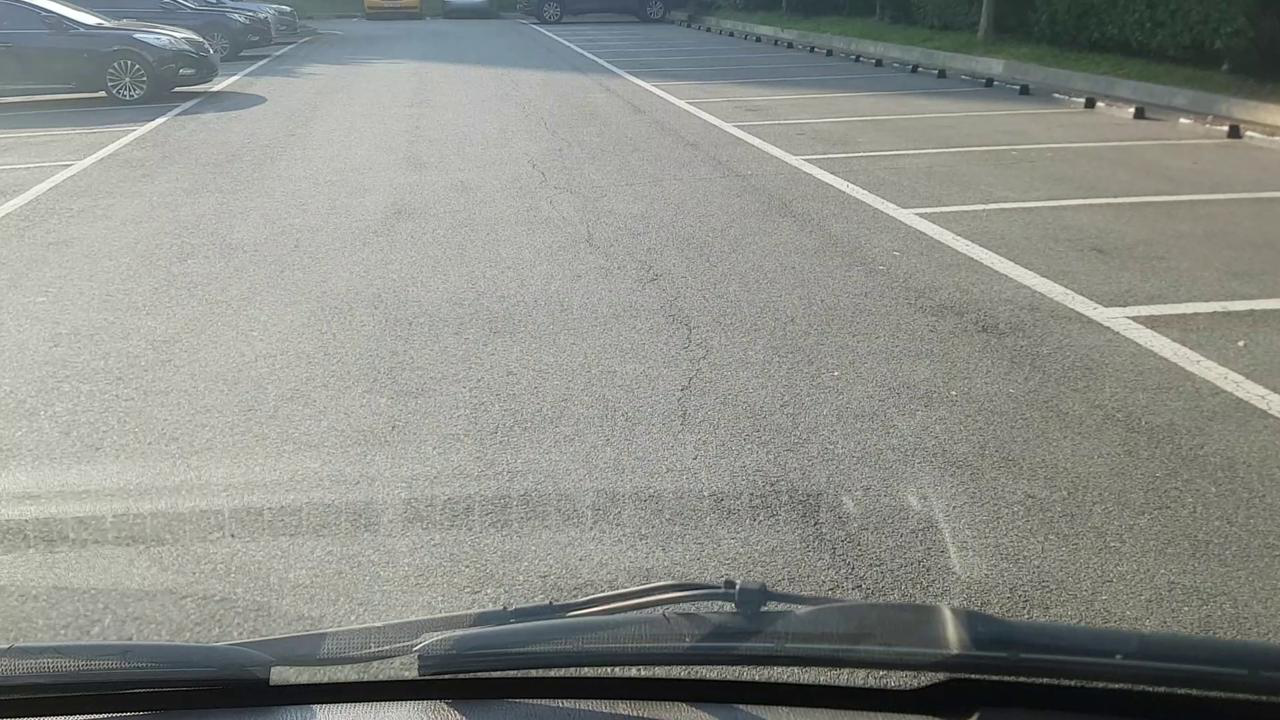

In [7]:
sample = df_train.iloc[1]

# 이미지 읽기
image_sample = Image.open(sample["image_path"])
image_sample

### 샘플 이미지의 라벨

라벨은 정규화된 XYWH 형식으로 작성되어 있습니다.

정규화된 XYWH 형식
`<object-class> <x> <y> <width> <height>`
- object-class: 물체의 클래스 (0부터 시작하는 정수)
- x, y: 바운딩 박스의 중심의 상대 좌표(0~1 사이 값)
- width, height: 바운딩 박스의 너비와 높이(0~1 사이 값)

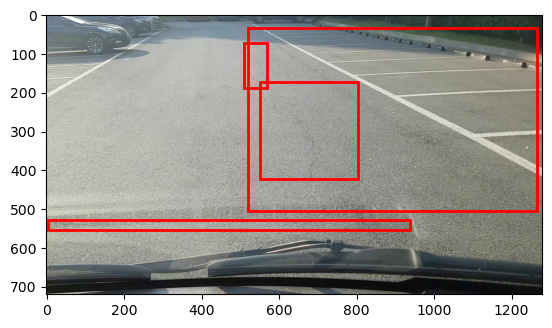

In [12]:
sample = df_train.iloc[1]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])

# 이미지 표시
ax.imshow(img)

# 박스 그리기
for label in sample["labels"]:
    # 좌표 변환
    c_x = label["x"] * img.width
    c_y = label["y"] * img.height
    w = label["w"] * img.width
    h = label["h"] * img.height

    left_top_x = c_x - w / 2
    left_top_y = c_y - h / 2

    rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=2, edgecolor="r", facecolor="none")
    ax.add_patch(rect)

fig.show()

## 데이터 전처리

### 데이터 분리

In [9]:
df_train_set = df_train.sample(frac=0.8, random_state=0)
df_valid_set = df_train.drop(df_train_set.index)

df_train_set.to_csv("train_set.csv", index=False)
df_valid_set.to_csv("valid_set.csv", index=False)

# 절대경로로 변환
new_train_path = '/root/ssm/cai/data/train'
new_valid_path = '/root/ssm/cai/data/val'

# 디렉토리 생성(이미지,라벨)
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)

#디렉토리 생성(이미지, 라벨)
os.makedirs(new_valid_path, exist_ok=True)
os.makedirs(os.path.join(new_valid_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_valid_path, LABELS_DIR), exist_ok=True)

In [9]:
df_train_set = df_train

df_train_set.to_csv("train_set.csv", index=False)

# 절대경로로 변환
new_train_path = '/root/ssm/cai/data/train'

# 디렉토리 생성(이미지,라벨)
os.makedirs(new_train_path, exist_ok=True)
os.makedirs(os.path.join(new_train_path, IMAGE_DIR), exist_ok=True)
os.makedirs(os.path.join(new_train_path, LABELS_DIR), exist_ok=True)


### 데이터 전처리 및 복사

이미지의 크기를 변경하고 각각 폴더에 복사합니다.

In [12]:
# 원본 이미지 크기: 1280x720
# 이미지 크기를 480x480으로 변경
IMAGE_SIZE = 480

#새로운 학습 데이터 경로
for i, row in tqdm(df_train_set.iterrows(), total=len(df_train_set)):
    image = Image.open(row["image_path"])
    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_train_path}/{IMAGE_DIR}/{row['id']}.jpg")
    shutil.copy(row["label_path"], f"{new_train_path}/{LABELS_DIR}/{row['id']}.txt")

#새로운 검증 데이터 경로
#for i, row in tqdm(df_valid_set.iterrows(), total=len(df_valid_set)):
#    image = Image.open(row["image_path"])
#    image.resize((IMAGE_SIZE, IMAGE_SIZE)).save(f"{new_valid_path}/{IMAGE_DIR}/{row['id']}.jpg")
#    shutil.copy(row["label_path"], f"{new_valid_path}/{LABELS_DIR}/{row['id']}.txt")

  0%|          | 110/30338 [00:03<14:03, 35.82it/s]


KeyboardInterrupt: 

In [5]:
import os

def check_if_same_file(path1, path2):
    try:
        # 절대 경로로 변환하여 비교
        abs_path1 = os.path.abspath(path1)
        abs_path2 = os.path.abspath(path2)
        
        # 같은 파일인지 비교
        return os.path.samefile(abs_path1, abs_path2)
    except OSError as e:
        # 오류가 발생하면 False 반환
        print(f"Error checking files: {e}")
        return False

path1 = './train/labels/b28a0d9768fb7ae3db4be6f0.txt'
path2 = '/root/caicon/train/labels/b28a0d9768fb7ae3db4be6f0.txt'

if check_if_same_file(path1, path2):
    print("The paths refer to the same file.")
else:
    print("The paths refer to different files.")

Error checking files: [Errno 2] No such file or directory: '/root/caicon/train/labels/b28a0d9768fb7ae3db4be6f0.txt'
The paths refer to different files.


In [9]:
import os

def count_files_in_directory(directory):
    # 디렉토리 내 모든 파일을 세는 함수
    file_count = 0
    for root, dirs, files in os.walk(directory):
        file_count += len(files)  # 파일 개수를 누적
    return file_count

# 사용할 디렉토리 경로 설정
directory_path = '/root/caicon/data/train/images'

# 파일 개수 출력
print(f"총 파일 개수: {count_files_in_directory(directory_path)}")


총 파일 개수: 30338


## 모델 학습

### 모델 준비

외부 모델을 사용하는 경우 아래처럼 모델을 불러올 수 있습니다.

- 다운로드 하는 코드를 명시
- 필요한 종속성을 설치하는 코드를 명시

In [7]:
# YOLOv8 클론 및 설치 
!pip install ultralytics

from ultralytics import YOLO

import os
from shutil import copyfile

### 모델 학습

In [23]:
dataset = {
    "path": os.path.abspath("."),
    "train": "train",
    "val": "valid",
    "nc": 2,
    # crack = 도로 균열, pothole = 포트홀
    "names": ["crack", "pothole"],
}

YAML_PATH = os.path.abspath("pothole.yaml")
RESULT_PATH = os.path.abspath("result")
os.makedirs(RESULT_PATH, exist_ok=True)
with open(YAML_PATH, "w") as f:
    yaml.dump(dataset, f)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 첫 번째 GPU 사용


import torch
print(torch.cuda.is_available())  # True가 출력되면 GPU 인식 가능
print(torch.cuda.device_count())  # 사용 가능한 GPU 개수
print(torch.cuda.get_device_name(0))  # 첫 번째 GPU의 이름 출력



True
1
GRID A100X-10C


In [10]:
# Train the YOLOv8 model
model = YOLO('yolov8m.yaml')  # Load a YOLOv8 nano model

# Set up training
results = model.train(data='/root/ssm/cai/data.yaml',  # Path to dataset
                      epochs=30,  # You can adjust epochs
                      batch=16,   # Adjust batch size
                      imgsz=640,  # Image size
                      name='road_detection')  # Name of the experiment

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [24]:
# Train the YOLOv8 model
model = YOLO('yolov8n.yaml')  # Load a YOLOv8 nano model

# Set up training
results = model.train(data=YAML_PATH,  # Path to dataset
                      epochs=20,  # You can adjust epochs
                      batch=32,   # Adjust batch size
                      imgsz=640,  # Image size
                      name='road_detection',
                      device=0
                      )  # Name of the experiment

Ultralytics YOLOv8.2.93 🚀 Python-3.11.7 torch-2.4.1+cu118 CUDA:0 (GRID A100X-10C, 10236MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/root/caicon/pothole.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=road_detection16, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

RuntimeError: Dataset '/root/caicon/pothole.yaml' error ❌ 
Dataset '/root/caicon/pothole.yaml' images not found ⚠️, missing path '/root/caicon/valid'
Note dataset download directory is '/root/seungmu/datasets'. You can update this in '/root/.config/Ultralytics/settings.yaml'

In [27]:
model.save('best.pt')  # 원하는 경로에 가중치 저장


TypeError: 'NoneType' object is not a mapping

In [15]:
!PYTHONWARNINGS="ignore::FutureWarning" python yolov7/train.py --img 480 --batch 32 --epoch 15 --data {YAML_PATH} --cfg yolov7.yaml --exist-ok --name pothole --project {RESULT_PATH}

Traceback (most recent call last):
  File "yolov7/train.py", line 587, in <module>
    opt.data, opt.cfg, opt.hyp = check_file(opt.data), check_file(opt.cfg), check_file(opt.hyp)  # check files
  File "/root/caicon/yolov7/utils/general.py", line 152, in check_file
    assert len(files) == 1, f"Multiple files match '{file}', specify exact path: {files}"  # assert unique
AssertionError: Multiple files match 'yolov7.yaml', specify exact path: ['./yolov7/cfg/deploy/yolov7.yaml', './yolov7/cfg/training/yolov7.yaml']


In [30]:
from ultralytics import YOLO
import os

# Load the trained YOLOv8 model
model = YOLO(' runs/detect/road_detection18/weights/best.pt')  # 학습된 best 가중치 로드

# 검증 이미지 경로 설정
VALID_PATH = '/root/ssm/cai/data/val'  # 검증 데이터셋 경로
IMAGE_DIR = 'images'  # 이미지 폴더명

# 검증 데이터에 대한 예측 수행
model.predict(
    source=os.path.join(VALID_PATH, IMAGE_DIR),  # 검증 이미지 경로
    conf=0.25,  # Confidence threshold 설정 (필요에 따라 조정 가능)
    save=True,  # 결과 이미지 저장
    save_txt=True,  # 예측 결과를 텍스트 파일로 저장
    save_conf=True,  # confidence score 저장
    project='runs/predict/road_detection',  # 결과 저장 경로
    name='valid_predictions',  # 결과 저장 디렉토리 이름
    exist_ok=True  # 동일 경로가 존재해도 덮어쓰기 가능
)




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/6068 /root/ssm/cai/data/val/images/00199c49c21db29a9814e779.jpg: 640x640 1 crack, 6.3ms
image 2/6068 /root/ssm/cai/data/val/images/001fe8562e7718ca2d9d3da9.jpg: 640x640 4 cracks, 7.8ms
image 3/6068 /root/ssm/cai/data/val/images/002e0f2daa860fb9d22cdd41.jpg: 640x640 1 crack, 6.3ms
image 4/6068 /root/ssm/cai/data/val/images/003e5418c86b91df075c7961.jpg: 640x640 1 crack, 7.4ms
image 5/6068 /root/ssm/cai/data/val/images/005ed832d8b45f25a930aa5a.jpg

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'crack', 1: 'pothole'}
 obb: None
 orig_img: array([[[212, 198, 170],
         [208, 194, 166],
         [212, 198, 170],
         ...,
         [115, 159, 160],
         [127, 171, 172],
         [136, 180, 181]],
 
        [[212, 198, 170],
         [209, 195, 167],
         [212, 198, 170],
         ...,
         [110, 155, 159],
         [119, 164, 168],
         [126, 171, 175]],
 
        [[212, 198, 169],
         [209, 195, 166],
         [213, 199, 170],
         ...,
         [109, 154, 167],
         [112, 160, 172],
         [116, 164, 176]],
 
        ...,
 
        [[103,  98,  97],
         [102,  97,  96],
         [103,  96,  93],
         ...,
         [ 61,  57,  52],
         [ 62,  58,  53],
         [ 62,  58,  53]],
 
        [[101,  96,  95],
         [102,  97,  96],
         [105,  98,  95],
         ...,
     

In [1]:
import os

# 경로로 이동
os.chdir('runs/predict/road_detection/valid_predictions')

# 현재 경로 확인
print(os.getcwd())


/root/caicon/runs/predict/road_detection/valid_predictions


## 모델 평가

### 검증 데이터 예측

In [ ]:

!python yolov5/detect.py --source {os.path.join(new_valid_path, IMAGE_DIR)} --weights {RESULT_PATH}/pothole/weights/best.pt --conf 0.1 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/valid

### 예측 결과 시각화

In [7]:
sample = df_valid_set.iloc[3]
fig, ax = plt.subplots()

img = Image.open(sample["image_path"])
ax.imshow(img)

# 예측 결과 시각화
predict = os.path.join(RESULT_PATH, "valid", "exp", "labels", sample["id"] + ".txt")
if os.path.exists(predict):
    with open(predict, "r") as f:
        for line in f.readlines():
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            c_x *= img.width
            c_y *= img.height
            w *= img.width
            h *= img.height

            left_top_x = c_x - w / 2
            left_top_y = c_y - h / 2

            rect = patches.Rectangle(
                (left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none"
            )
            ax.add_patch(rect)

# 정답 시각화
with open(sample["label_path"], "r") as f:
    for line in f.readlines():
        class_id, c_x, c_y, w, h = map(float, line.split())
        c_x *= img.width
        c_y *= img.height
        w *= img.width
        h *= img.height

        left_top_x = c_x - w / 2
        left_top_y = c_y - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="w", facecolor="none")
        ax.add_patch(rect)
fig.set_figheight(10)
fig.show()

NameError: name 'df_valid_set' is not defined

## 제출 파일 생성

### 테스트 데이터 예측

In [32]:
!rm -rf {RESULT_PATH}/test/exp


In [4]:
from ultralytics import YOLO
import os

# Load the trained YOLOv8 model
model = YOLO('/root/caicon/runs/detect/road_detection18/weights/best.pt')  # 학습된 best 가중치 로드

# 테스트 이미지 경로 설정
TEST_PATH = '/root/ssm/cai/data/test'  # 테스트 데이터셋 경로
IMAGE_DIR = 'images'  # 이미지 폴더명

# 결과를 저장할 경로 설정
RESULT_PATH = '/root/caicon/runs/predict'  # 결과를 저장할 기본 경로

# 테스트 데이터에 대한 예측 수행
model.predict(
    source=os.path.join(TEST_PATH, IMAGE_DIR),  # 테스트 이미지 경로
    conf=0.25,  # Confidence threshold 설정 (필요에 따라 조정 가능)
    save=True,  # 결과 이미지 저장
    save_txt=True,  # 예측 결과를 텍스트 파일로 저장
    save_conf=True,  # confidence score 저장
    project=os.path.join(RESULT_PATH, 'valid'),  # 결과 저장 경로, {RESULT_PATH}/valid
    name='test_predictions',  # 결과 저장 디렉토리 이름
    exist_ok=True  # 동일 경로가 존재해도 덮어쓰기 가능
)




WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/7043 /root/ssm/cai/data/test/images/000055e8f6d122e994484757.jpg: 384x640 1 crack, 39.7ms
image 2/7043 /root/ssm/cai/data/test/images/0005b3cac344a76e24863aaf.jpg: 384x640 (no detections), 7.7ms
image 3/7043 /root/ssm/cai/data/test/images/000bb5c5ce578b148414b592.jpg: 384x640 (no detections), 8.3ms
image 4/7043 /root/ssm/cai/data/test/images/000e2f6cccfec91021c9e353.jpg: 384x640 2 cracks, 10.1ms
image 5/7043 /root/ssm/cai/data/test/images/000f9

: 

In [10]:
import os

# 경로로 이동
os.chdir('/root/caicon/runs/predict')

# 현재 경로 확인
print(os.getcwd())


/root/caicon/runs/predict


In [ ]:
!python yolov5/detect.py --source {os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR)} --weights {RESULT_PATH}/pothole/weights/best.pt --conf 0.1 --save-txt --save-conf --exist-ok --project {RESULT_PATH}/test

### 바운드 박스 읽어오기

In [32]:
RESULT_PATH = '/root/caicon/runs/predict/road_detection/road_detection/test_predictions' 
for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    #label_path = os.path.join(RESULT_PATH, "test", "exp", "labels", row["id"] + ".txt")
    label_path='/root/caicon/runs/predict/road_detection/road_detection/test_predictions/labels'

    labels = []
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            class_id, c_x, c_y, w, h, conf = map(float, line.split())
            labels.append({"class_id": int(class_id), "conf": float(conf), "x": c_x, "y": c_y, "w": w, "h": h})

    df_test.at[i, "labels"] = labels
df_test

SyntaxError: invalid syntax (2768566016.py, line 4)

### 생성되는 CSV 파일의 형식

CSV 파일은 각 이미지에 대한 정보를 포함하며, 다음과 같은 열(column)로 구성됩니다: 

| id        | labels                             | 
|-----------|------------------------------------| 
| image_id  | [{"class_id": ..., "conf": ..., "x": ..., "y": ..., "w": ..., "h": ...}, ...] | 

각 행(row)은 다음과 같은 내용을 포함합니다: 
- id: 이미지의 고유 식별자 (image_id) 
- labels: 해당 이미지에 대한 라벨 정보를 포함하는 리스트 
  - 각 라벨은 다음과 같은 정보를 포함합니다: 
    - class_id: 객체의 클래스 ID (정수형)
    - x: 객체의 정규화된 x 좌표 (0 이상 1 이하)
    - y: 객체의 정규화된 y 좌표 (0 이상 1 이하)
    - w: 객체의 정규화된 너비 (0 이상 1 이하)
    - h: 객체의 정규화된 높이  (0 이상 1 이하)
    - conf: 객체 탐지 결과의 신뢰도 (0 이상 1 이하)

conf 값은 생략할 수 있으며, 생략할 경우 채점 프로그램은 해당 라벨의 conf 값을 1.0 으로 간주합니다.

또한, 채점 프로그램은 각 라벨이 정규화된 XYWH 포맷으로 작성되었다고 간주합니다.

예시: 
| id         | labels                                                       | 
|------------|--------------------------------------------------------------| 
| image_001  | [{"class_id": 1, "conf": 0.3, "x": 0.5, "y": 0.5, "w": 0.2, "h": 0.3}] | 
| image_002  | [{"class_id": 0, "conf": 0.8, "x": 0.3, "y": 0.4, "w": 0.1, "h": 0.2}, {"class_id": 1, "conf": 1, "x": 0.7, "y": 0.8, "w": 0.15, "h": 0.25}] | 

주의: x, y, w, h는 각각 이미지의 너비와 높이에 대한 비율로 표현되며, 
      x와 y는 객체의 중심 좌표를 기준으로 하고, w와 h는 객체의 크기를 나타냅니다.

### 제출 파일 생성

In [30]:
submission = []

for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    image_id = row["id"]
    labels = []
    for label in row["labels"]:
        class_id = label["class_id"]
        x = label["x"]
        y = label["y"]
        w = label["w"]
        h = label["h"]
        conf = label["conf"]

        labels.append({"class_id": class_id, "conf": conf, "x": x, "y": y, "w": w, "h": h})
    submission.append({"id": image_id, "labels": labels})

df_submission = pd.DataFrame(submission)
df_submission.to_csv("submission.csv", index=False)

print(df_submission)

100%|██████████| 7043/7043 [00:00<00:00, 16057.43it/s]

                            id labels
0     000055e8f6d122e994484757     []
1     0005b3cac344a76e24863aaf     []
2     000bb5c5ce578b148414b592     []
3     000e2f6cccfec91021c9e353     []
4     000f949f37337be8615f58ca     []
...                        ...    ...
7038  ffa65133b5dd7bff346a2d06     []
7039  ffced8c4135c86682921b557     []
7040  ffd0a84c3eb0ef5231c107c1     []
7041  ffed89636887ed503b1e10ea     []
7042  fff886478e1a88d76809cd9e     []

[7043 rows x 2 columns]


### 제출 파일 확인

제출한 파일이 올바른 형식인지 확인합니다.

In [29]:
df_submission = pd.read_csv("submission.csv")

sample = df_submission.iloc[9]
sample_labels = eval(sample["labels"])

if len(sample_labels) == 0:
    print("예측결과: 해당 도로 이미지에선 발견된 균열 및 구멍이 없습니다.")
else:
    fig, ax = plt.subplots()
    img = Image.open(os.path.join(DATASET_ROOT, TEST_DIR, IMAGE_DIR, sample["id"] + ".jpg"))
    ax.imshow(img)

    # 예측 결과 시각화
    for label in sample_labels:
        class_id = label["class_id"]
        cx = label["x"] * img.width
        cy = label["y"] * img.height
        w = label["w"] * img.width
        h = label["h"] * img.height

        left_top_x = cx - (w / 2)
        left_top_y = cy - h / 2

        rect = patches.Rectangle((left_top_x, left_top_y), w, h, linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)

예측결과: 해당 도로 이미지에선 발견된 균열 및 구멍이 없습니다.


## 제출

1. 규정에 따라 `code.ipynb`, `requirements.txt` 파일을 포함하여 모델의 성능 재현에 필요한 모든 파일을 압축한 `code.zip` 파일을 제출 환경에 업로드 합니다.
   1. 리눅스 환경에서는 다음 명령어를 활용하여 압축 파일을 생성할 수 있습니다: `zip code.zip code.ipynb requirements.txt`
   2. 다른 파이썬 파일을 사용한 경우 위 명령어 뒤에 파일명을 추가하면 됩니다.
   3. 특정 폴더를 압축해야 하는 경우 `zip -r code.zip code.ipynb requirements.txt 원하는/폴더/경로` 와 같은 명령어를 활용할 수 있습니다.
2. 그 후, `submission.csv` 파일을 업로드 합니다.
3. 두 파일이 업로드 된 것을 확인한 후, 오른쪽 위의 '제출' 버튼을 클릭하여 제출합니다.

## 제출 주의사항
1. `code.zip` 파일과 `submission.csv` 파일을 시스템이 압축한 파일의 용량이 50MB를 넘으면 안됩니다.
2. `code.zip` 파일 안에 `code.ipynb` 파일과 `requirements.txt` 파일이 있어야 합니다. 

아래 코드를 실행하면 제출 주의사항을 모두 만족했는지 확인하실 수 있습니다.

In [9]:
import os
import zipfile

is_ready = True

# code.zip 파일이 생성되었는지 확인합니다.
if os.path.exists("code.zip"):
    result_zip = zipfile.ZipFile('code.zip')
    # 파일 목록을 확인합니다.
    submission_filelist = result_zip.namelist()
    if (
        "code.ipynb" not in submission_filelist
        or "requirements.txt" not in submission_filelist
    ):
        is_ready = False
        print("압축 파일에 필요한 파일이 모두 있는지 확인해주세요.")
else:
    is_ready = False
    print("code.zip 파일이 생성되었는지 확인해주세요.")

# submission.csv 파일이 생성되었는지 확인합니다.
if not os.path.exists("submission.csv"):
    is_ready = False
    print("submission.csv 파일이 생성되었는지 확인해주세요.")

if is_ready:
    # 파일의 용량을 확인합니다. 
    # 시스템 상 두 제출 파일을 압축한 후 50MB를 넘지 않으면 제출할 수 있으므로, 용량의 합이 50MB보다 약간 클 경우 제출이 가능할 수 있습니다.
    if os.path.getsize("code.zip") + os.path.getsize("submission.csv") > 50e6:
        print("제출 파일의 용량이 50MB를 초과하고 있습니다. 제출 전 용량을 줄여주세요.")
    else:
        print("제출할 준비가 되었습니다.")
else:
    print("제출 주의사항을 모두 만족하는지 확인해주세요.")

code.zip 파일이 생성되었는지 확인해주세요.
제출 주의사항을 모두 만족하는지 확인해주세요.
